In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
from PIL import Image


from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tifffile as tiff

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
images_path = '/content/drive/MyDrive/Water Segmentation/Data/images/'
labels_path = '/content/drive/MyDrive/Water Segmentation/Data/labels/'

In [3]:
folder_path = '/content/drive/MyDrive/Water Segmentation/Data/labels'

for filename in sorted(os.listdir(folder_path)):
    if '_' in filename:
        file_path = os.path.join(folder_path, filename)
        print(f"Deleted: {file_path}")
        os.remove(file_path)

In [32]:
def compute_ndwi(img, green_channel = 2, nir_channel = 4):
    green = img[:, :, green_channel]
    nir = img[:, :, nir_channel]
    ndwi = (green - nir) / (green + nir + 1e-5)
    return ndwi

def image_read(img_path, mask_path):
    images = []
    masks = []

    for file_name in sorted(glob.glob(img_path)):

        img = tiff.imread(file_name)

        # Transpose if shape is (12, H, W)
        if img.ndim == 3 and img.shape[0] == 12:
            img = np.transpose(img, (1, 2, 0))  # (H, W, 12)

        # Compute NDWI
        ndwi_map = compute_ndwi(img)
        ndwi_map = ndwi_map[..., np.newaxis]  # shape: (H, W, 1)

        # Concatenate NDWI as 13th channel
        img = np.concatenate([img, ndwi_map], axis=-1)  # shape: (H, W, 13)

        # Normalize each channel independently
        img = img.astype(np.float32)
        img = (img - np.min(img, axis=(0, 1))) / (np.max(img, axis=(0, 1)) - np.min(img, axis=(0, 1)) + 1e-5)

        images.append(img)

    # Read masks
    for file_name in sorted(glob.glob(mask_path)):
        mask = Image.open(file_name)
        mask = np.array(mask)
        masks.append(mask)

    return np.stack(images), np.stack(masks)


In [33]:
images, masks  = image_read(images_path + '*.tif', labels_path + '*.png')

In [34]:
images.shape, masks.shape

((306, 128, 128, 13), (306, 128, 128))

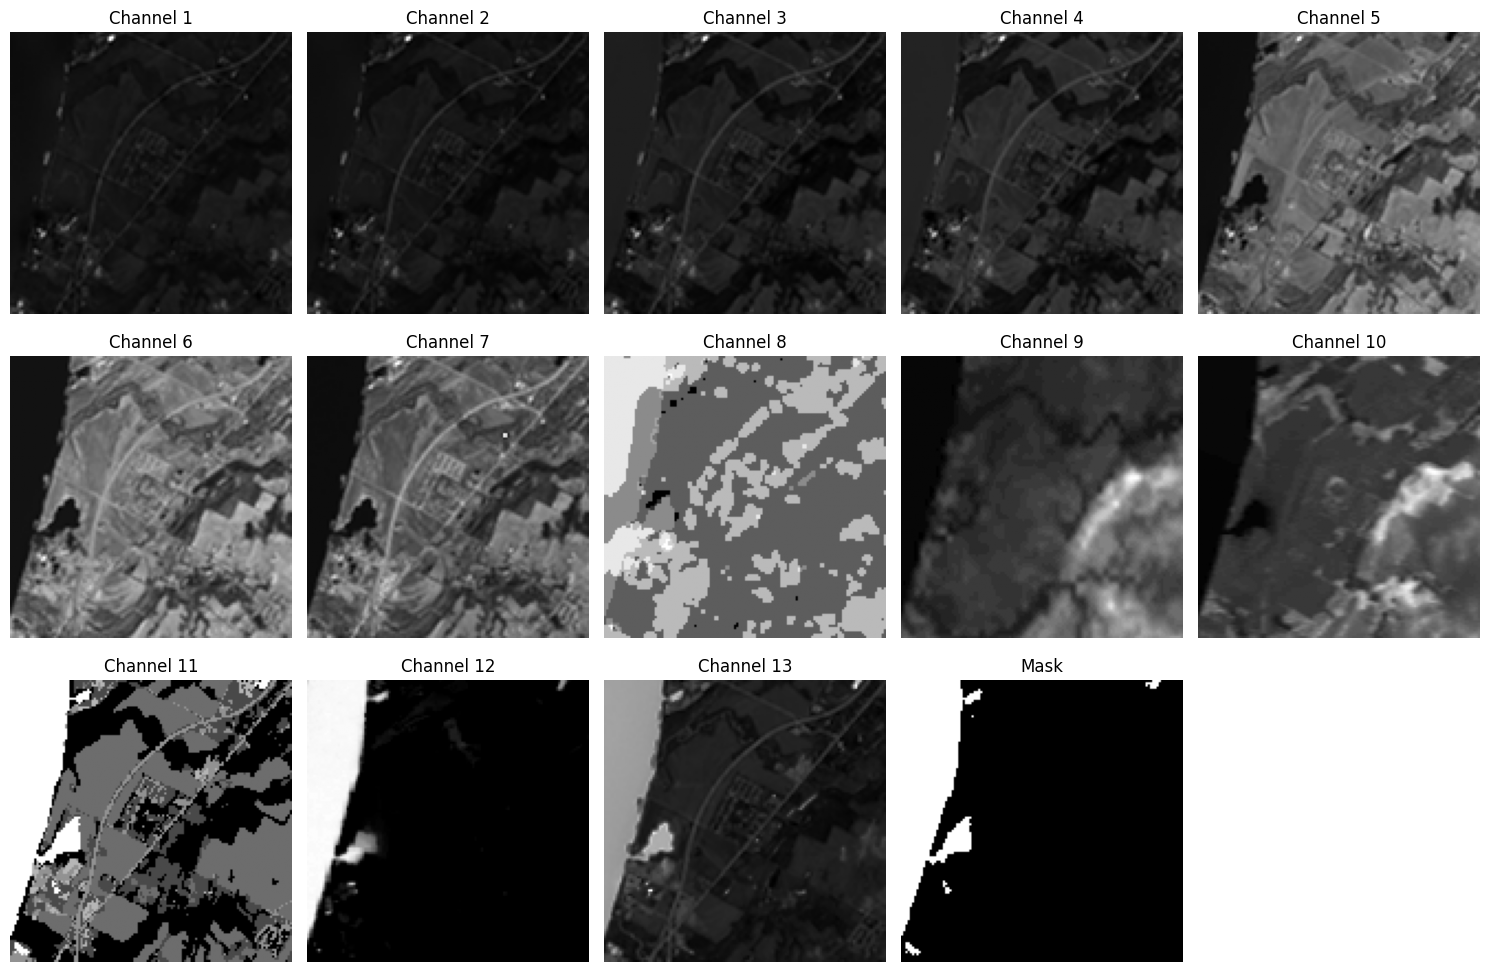

In [8]:
x = np.random.randint(0, images.shape[0])
mask = masks[x]
plt.figure(figsize=(15, 10))
for i in range(13):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[x][:, :, i], cmap='gray')
    plt.title(f'Channel {i+1}')
    plt.axis('off')

plt.subplot(3, 5, 14)
plt.imshow(mask, cmap='gray')
plt.title(f'Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

In [35]:
#Channels to keep
channels = [1,2,3,4,5,6,8,12]

images_selected = images[:, :, :, channels]

In [36]:
image_train, image_test, mask_train, mask_test = train_test_split(images_selected, masks, test_size=0.2, random_state=42)

In [37]:
image_train.shape, mask_train.shape

((244, 128, 128, 8), (244, 128, 128))

In [38]:
image_test.shape, mask_test.shape

((62, 128, 128, 8), (62, 128, 128))

In [39]:
def unet_model(input_size):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2),strides=(2,2), padding='same')(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2),strides=(2,2), padding='same')(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2),strides=(2,2), padding='same')(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    return model

In [46]:
import tensorflow.keras.backend as K
import tensorflow as tf

def iou_metric(y_true, y_pred):
    y_true = tf.cast(tf.expand_dims(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(K.round(y_pred), tf.float32)

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection

    return (intersection + 1e-6) / (union + 1e-6)

def dice_metric(y_true, y_pred):
    y_true = tf.cast(tf.expand_dims(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(K.round(y_pred), tf.float32)

    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + 1e-6) / (K.sum(y_true) + K.sum(y_pred) + 1e-6)


In [47]:
model = unet_model(input_size=(128, 128, 8))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[iou_metric, dice_metric])

In [48]:
history = model.fit(
    x= image_train,
    y= mask_train,
    steps_per_epoch=len(image_train) // 16,
    epochs=25
)

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - dice_metric: 0.2184 - iou_metric: 0.1641 - loss: 0.5084
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - dice_metric: 0.6916 - iou_metric: 0.5321 - loss: 0.3394
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - dice_metric: 0.7104 - iou_metric: 0.5527 - loss: 0.3633
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - dice_metric: 0.7136 - iou_metric: 0.5586 - loss: 0.3225
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - dice_metric: 0.7681 - iou_metric: 0.6287 - loss: 0.3013
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - dice_metric: 0.7424 - iou_metric: 0.5958 - loss: 0.3043
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - dice_metric: 0.7315 - iou_metric: 0.5849 - loss: 0.2926
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - dice_metric: 0.7558 - iou_metric: 0.6089 - loss: 0.2870
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - dice_metric: 0.7631 - iou_metric: 0.6238 - loss: 0.2858
Epoch 10/25


In [49]:
y_pred = model.predict(image_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step


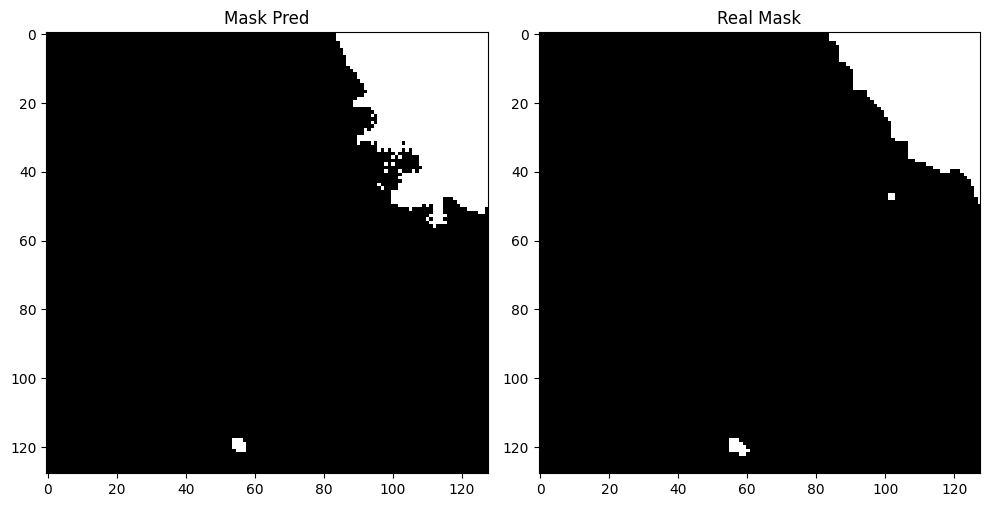

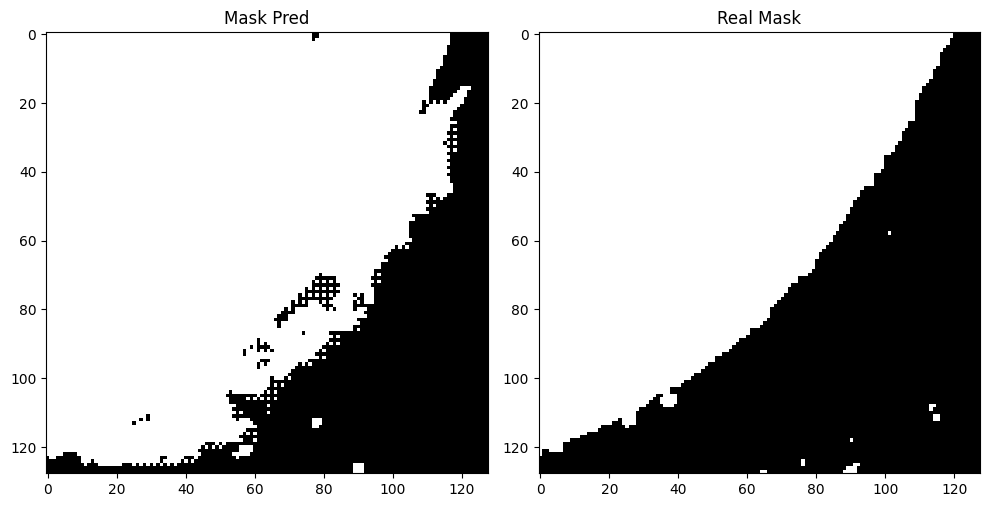

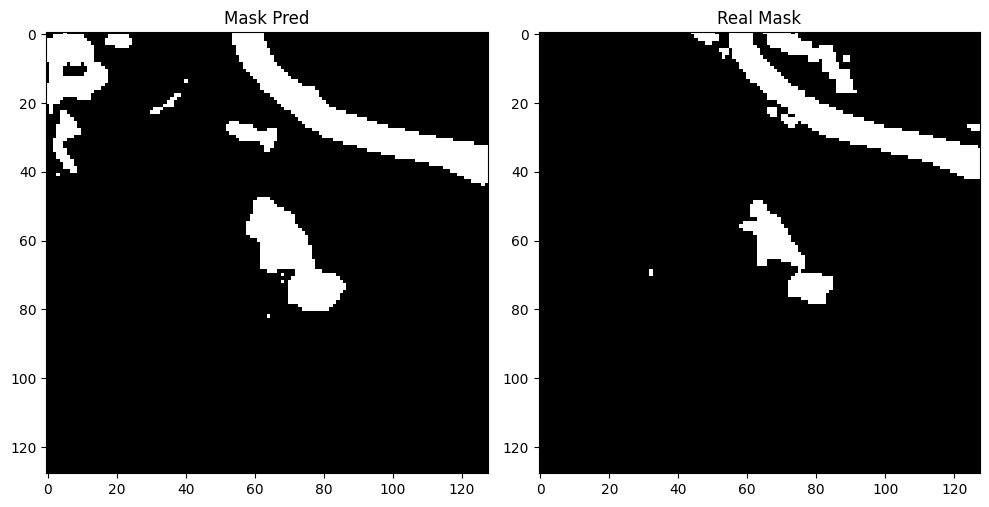

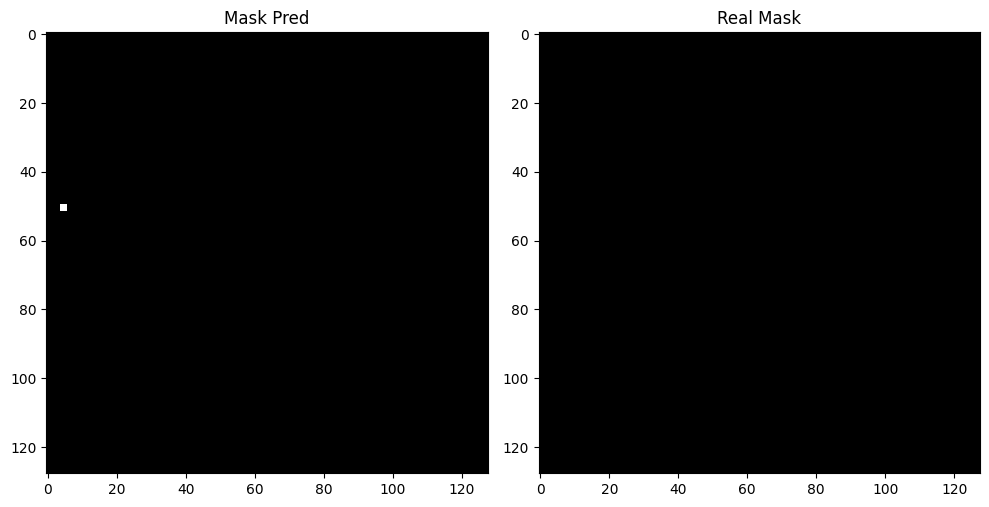

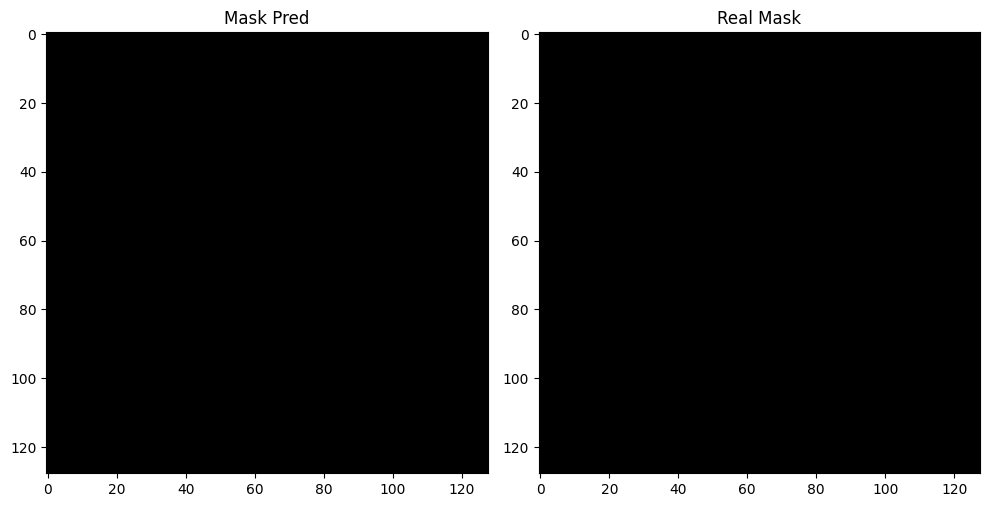

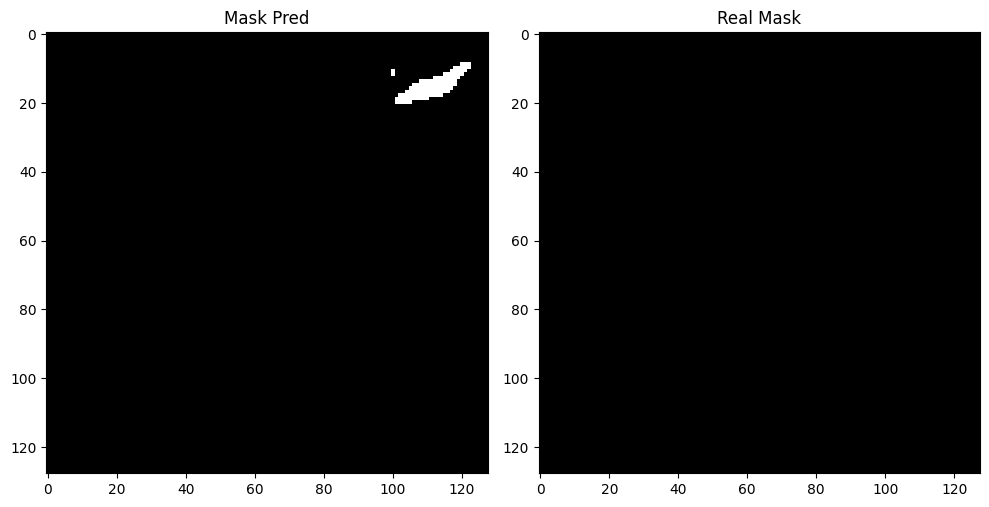

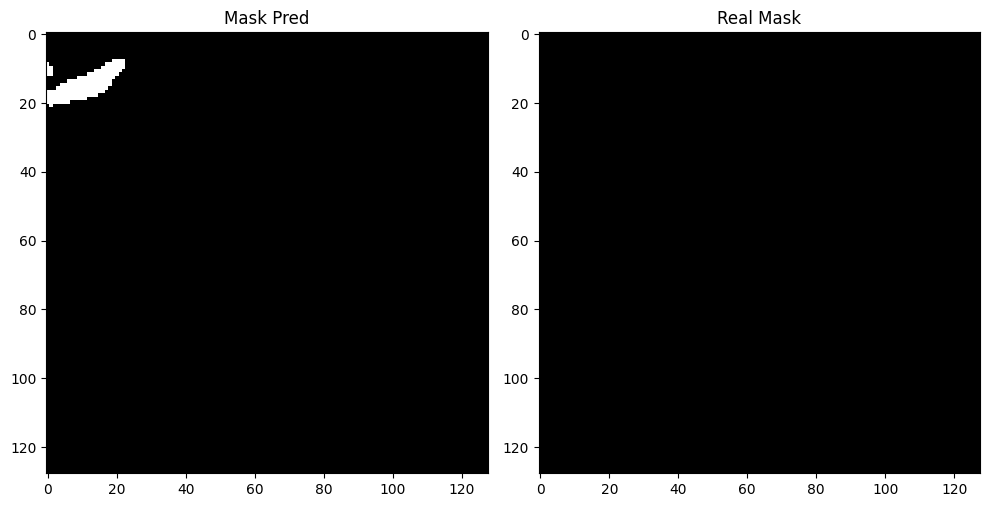

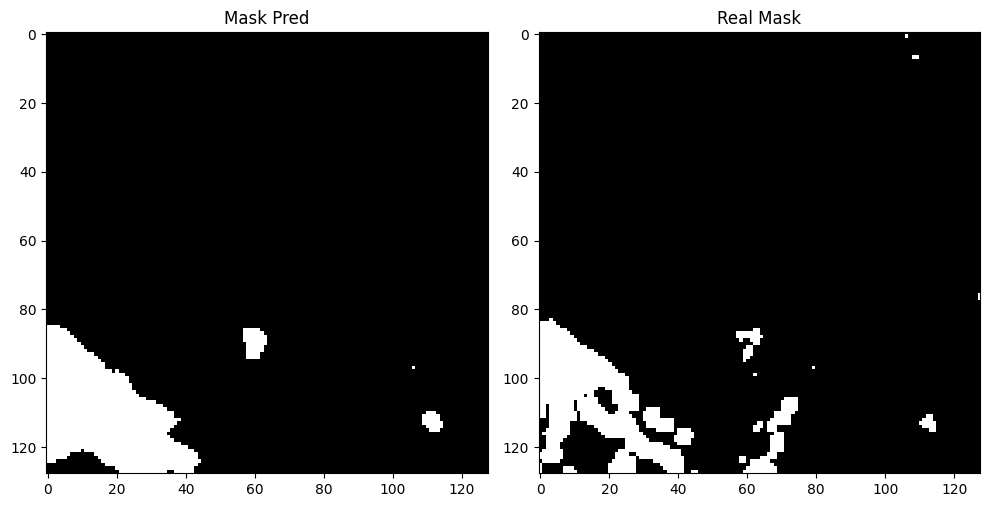

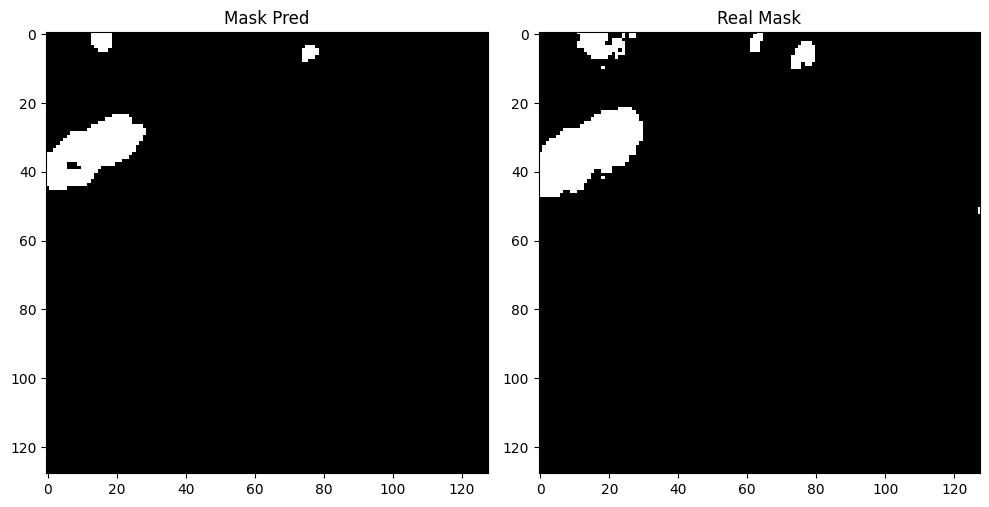

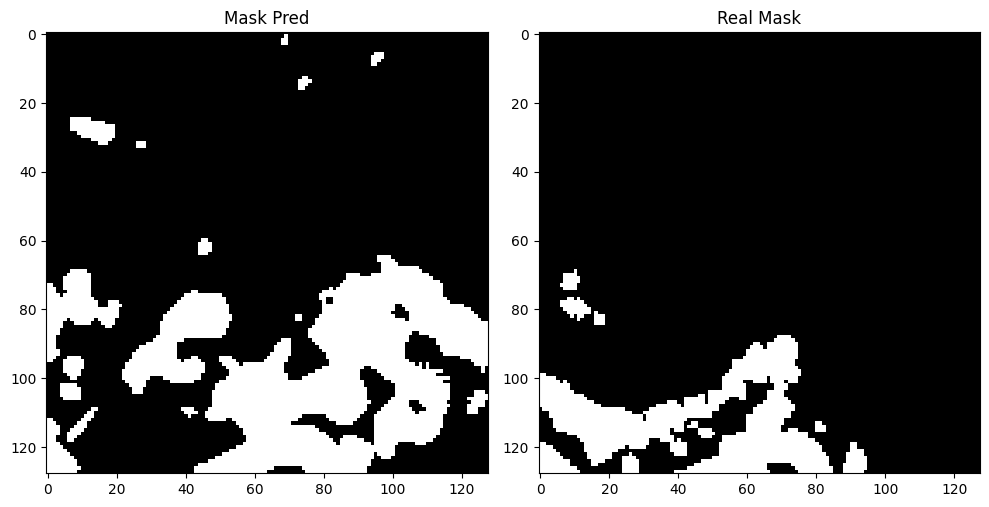

In [50]:
for i in range(10):
  plt.figure(figsize=(10, 8))
  x = np.random.randint(0, image_test.shape[0])

  plt.subplot(1, 2, 1)
  plt.imshow(y_pred[x], cmap='gray')
  plt.title('Mask Pred',)

  plt.subplot(1, 2, 2)
  plt.imshow(mask_test[x], cmap='gray')
  plt.title("Real Mask")

  plt.tight_layout()
  plt.show()

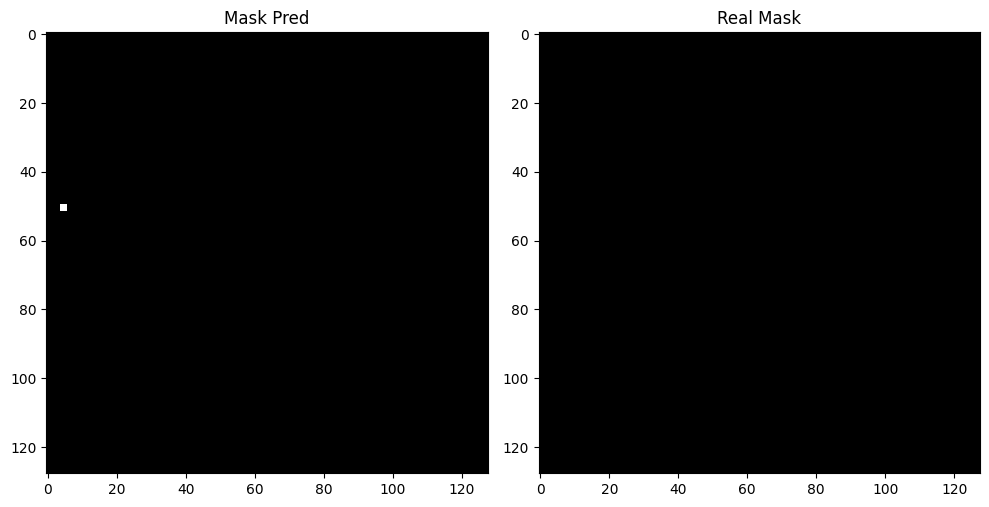

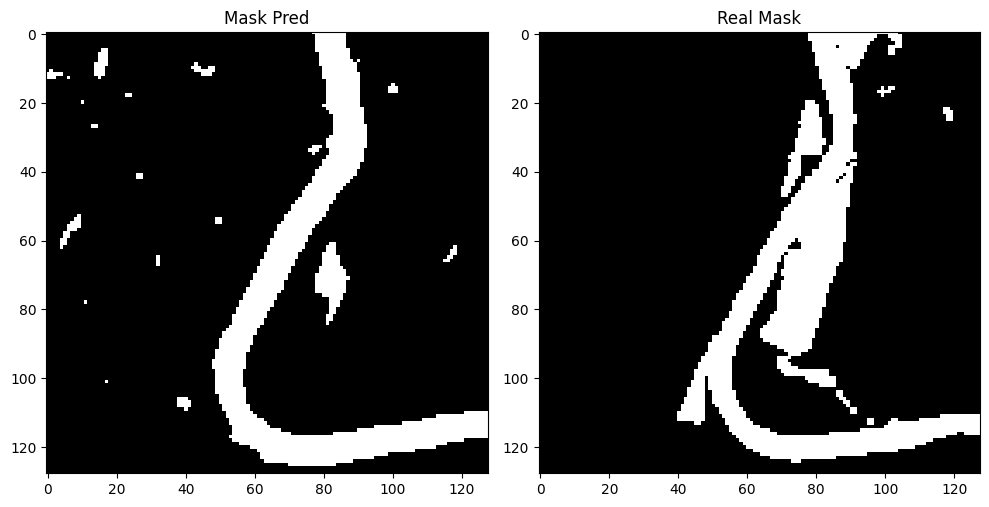

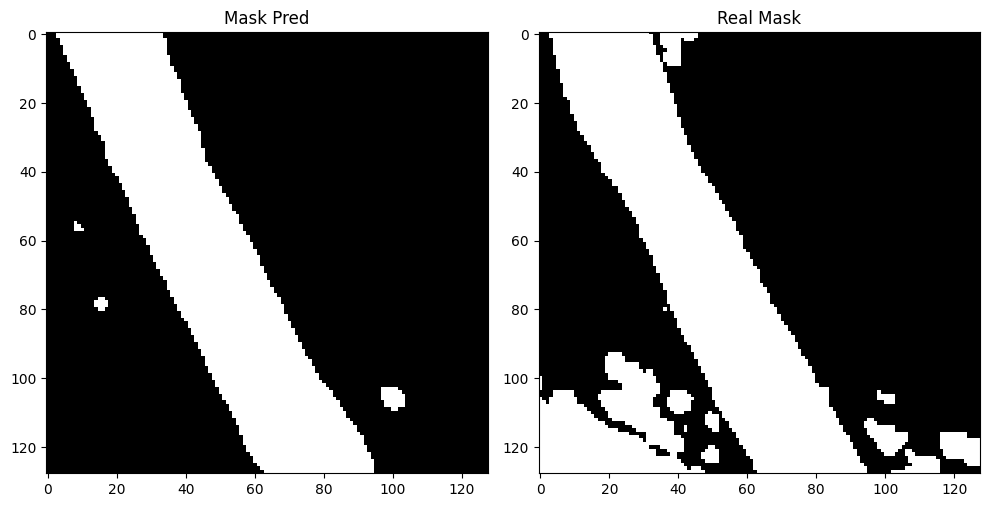

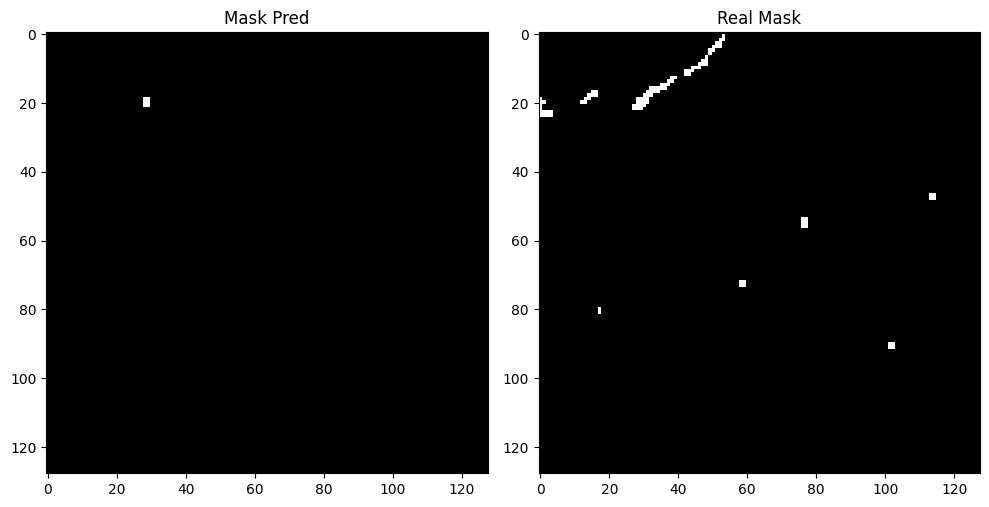

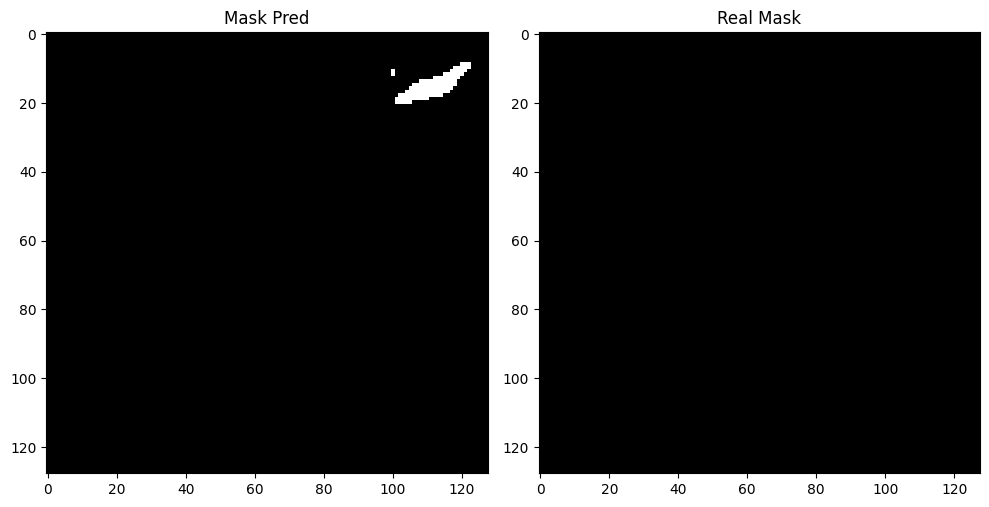

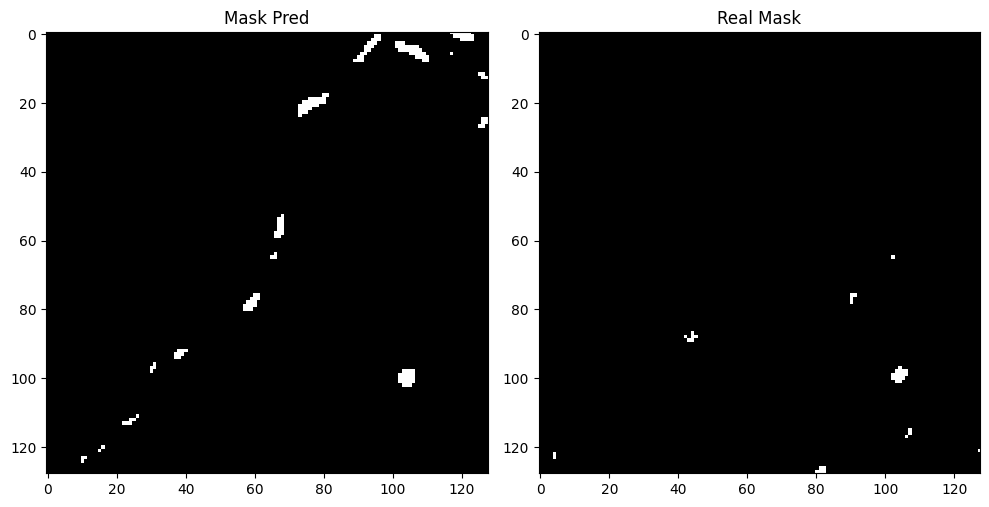

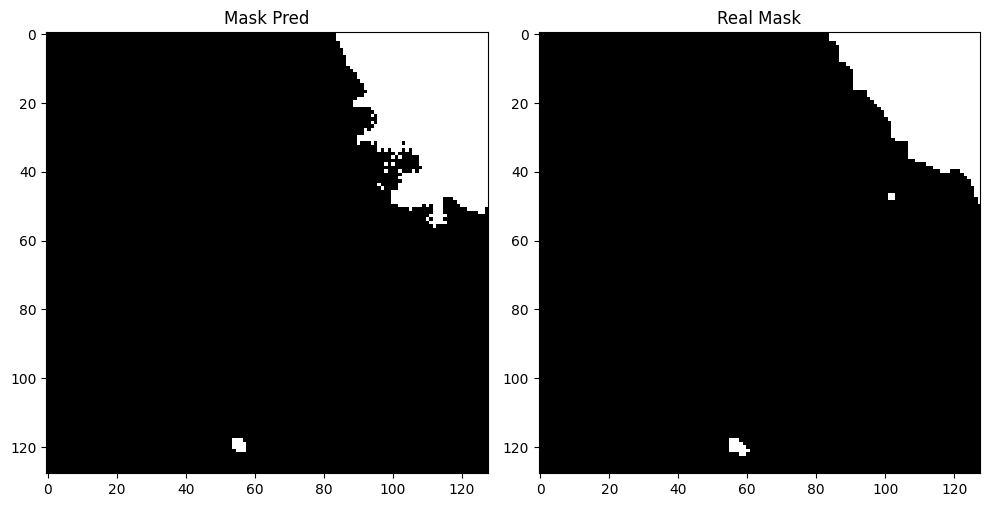

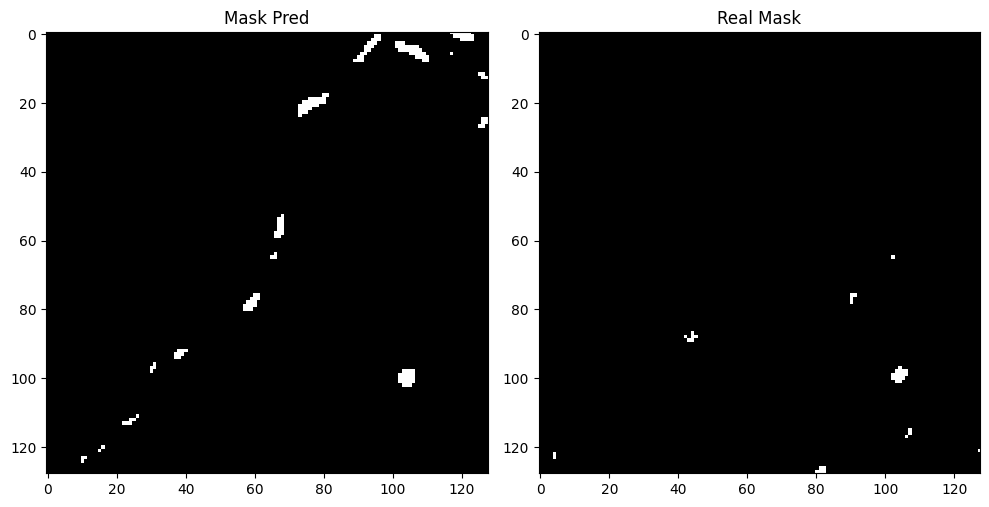

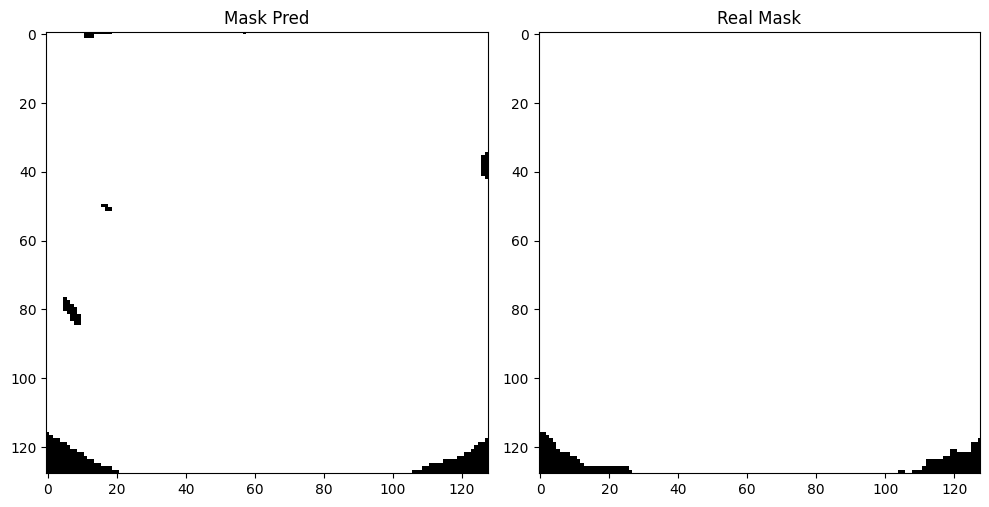

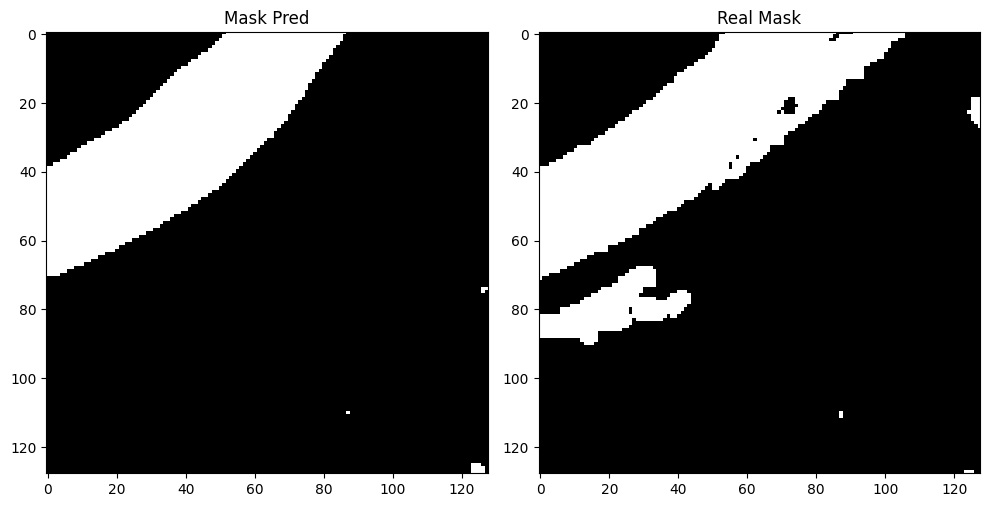

In [51]:
for i in range(10):
  plt.figure(figsize=(10, 8))
  x = np.random.randint(0, image_test.shape[0])

  plt.subplot(1, 2, 1)
  plt.imshow(y_pred[x], cmap='gray')
  plt.title('Mask Pred',)

  plt.subplot(1, 2, 2)
  plt.imshow(mask_test[x], cmap='gray')
  plt.title("Real Mask")

  plt.tight_layout()
  plt.show()